### Importing Packages

The following Python packages are imported for various functionalities:

- **numpy (np)**: Used for working with arrays, providing efficient mathematical operations on arrays.
- **pandas (pd)**: Utilized for working with dataframes, offering powerful data manipulation and analysis tools.
- **yfinance (yf)**: Employed to fetch financial data from Yahoo Finance, facilitating access to stock market data.
- **statsmodels.api (sm)**: Used for statistical analysis, including running regressions and other statistical models.
- **scipy.optimize (spop)**: Provides optimization tools for numerical optimization tasks, used here for optimizing the cointegration of the two tickers.
- **matplotlib.pyplot (plt)**: Utilized for result visualization, offering a wide range of plotting functions and customization options.

In [99]:
#importing packages
import numpy as np #to work with arrays
import pandas as pd #to work with dataframes
import yfinance as yf #to use yfin data
import statsmodels.api as sm # used to run regression and other stats model
import scipy.optimize as spop # for the numerical opti tool to optimize the cointegration of the two tickers
import matplotlib.pyplot as plt #for result visualisation

## KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test:
The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is a statistical test used to determine the stationarity of a time series data. It is often used alongside other stationarity tests like the Augmented Dickey-Fuller (ADF) test.

Key Points:

* Objective: The KPSS test aims to detect whether a given time series is stationary around a deterministic trend.
* `Null Hypothesis (H0)`: The null hypothesis of the KPSS test is that the data is stationary (trend-stationary or difference-stationary).
* `Alternative Hypothesis (H1)`: The alternative hypothesis is that the data is non-stationary.
* Critical Values: The test compares the calculated KPSS statistic against critical values to determine whether to accept or reject the null hypothesis.
* Interpretation: If the calculated KPSS statistic is greater than the critical value, the null hypothesis is rejected, indicating non-stationarity.

`Unbiased`: The variable unbiased is a parameter that determines whether the KPSS test is performed with or without bias.
When unbiased is set to 0 (as in the code), it indicates that the KPSS test is performed without bias.
In this context, `"bias"` refers to a correction applied to the KPSS test to make it unbiased. Bias can arise due to various factors, including sample size and model assumptions.
By setting unbiased to 0, the code specifies that the KPSS test should be performed without bias correction.

**Maximum KPSS Statistic**: `KPSS_max` is set to 0.463, representing the maximum KPSS statistic allowed. This value is based on the 95% critical value for the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, a method used to assess stationarity in time series data.

**KPSS Test Specification**: The variable `unbiased` is set to 0, indicating that the KPSS test is performed without bias. This test helps determine the stationarity of the data.

**Beta-Loading Specification**: `beta_loading` is set to 1, indicating that beta-loading is enabled. Beta-loading involves adjusting the trading positions based on the beta coefficients derived from regression analysis.

- **Rolling Window Length**: The variable `window` is set to 21, indicating the length of the rolling window used in the analysis. This window size determines the number of data points considered at each iteration.

**Strategy Parameters**: The trading strategy parameters are specified:
  - `fee`: Represents the trading fee applied to each transaction.
  - `entry`: Denotes the optimal entry threshold (divergence) used to trigger trading signals.
  - `stop_loss`: Defines the stop-loss threshold, indicating the maximum tolerable loss before exiting a trade.
  
**Initial Conditions**: Initial variables for trading signals and returns are set:
  - `signal`: Initialized as 0, indicating no trading signal initially.
  - `current_return`: Initialized as 0, representing the cumulative return from trading activities.
  - `position0` and `position1`: Initial positions for the assets in the pair, both set to 0 initially.
  
**Sample Specification**: The time period for the analysis is set:
  - `start`: Specifies the start date of the sample period.
  - `end`: Specifies the end date of the sample period.
  
**Asset Pair and Market Index**: The assets and market index to be analyzed are specified:
  - `tickers`: Specifies the pair of assets ('GAIL.NS' and 'ONGC.NS') to be analyzed.
  - `market`: Specifies the market index ('^NSEI') used for comparison and benchmarking.


In [100]:
#specifying rolling window length
window = 21
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463
#specifying the KPSS(Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test)) test (one-parameter unbiased or two-parameter)
unbiased = 0
#specifying whether to perform beta-loading or not
beta_loading = 1
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2021-09-28'
end = '2023-09-28'
#specifying the pair
tickers = ['GAIL.NS', 'ONGC.NS']
#specifying the market index
market = '^NSEI'

## Initializing Arrays and Downloading Price Data
- **gross_returns**: An empty NumPy array initialized to store gross returns from trading.
- **net_returns**: Another empty NumPy array initialized to store net returns after deducting trading fees.
- **market_returns**: An empty NumPy array initialized to store returns of the market index.
- **signals**: An empty NumPy array initialized to store trading signals.
- **KPSS_stats**: An empty NumPy array initialized to store KPSS statistics.
- **raw_data**: An empty pandas DataFrame initialized to store raw price data.

For each ticker:
- The price data is downloaded using the `yfinance` library within the specified start and end dates.
- The closing prices of the ticker are stored in the `raw_data` DataFrame under the respective ticker column.
- Finally, price data for the market index is downloaded and stored in the `raw_data` DataFrame under the column name 'market'.


In [101]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [102]:
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]]) 
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)


C:\Users\USER\AppData\Local\Temp\ipykernel_5696\1399539714.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
C:\Users\USER\AppData\Local\Temp\ipykernel_5696\1399539714.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
C:\Users\USER\AppData\Local\Temp\ipykernel_5696\1399539714.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered
stop-loss triggered


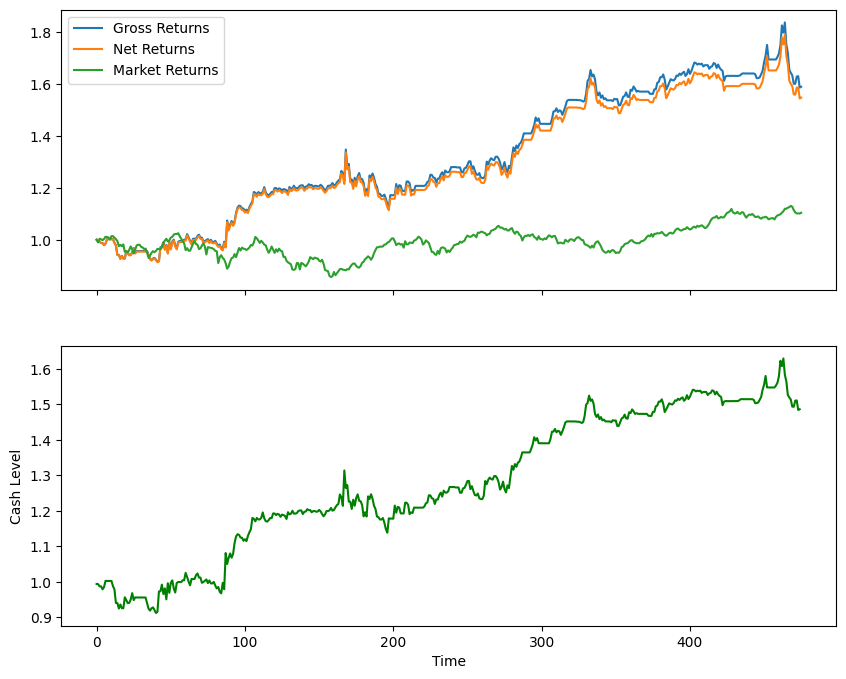

In [103]:
# #building the output dataframe
# output = pd.DataFrame()
# output['KPSS'] = KPSS_stats
# output['signal'] = signals
# output['gross'] = gross_returns
# output['net'] = net_returns
# output['market'] = market_returns
# #visualising the results
# plt.plot(np.append(1,np.cumprod(1+gross_returns)))
# plt.plot(np.append(1,np.cumprod(1+net_returns)))
# plt.plot(np.append(1,np.cumprod(1+market_returns)))

# Visualizing the results with subplot for cash level
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plotting cumulative returns
ax1.plot(np.append(1,np.cumprod(1+gross_returns)), label='Gross Returns')
ax1.plot(np.append(1,np.cumprod(1+net_returns)), label='Net Returns')
ax1.plot(np.append(1,np.cumprod(1+market_returns)), label='Market Returns')
ax1.legend()

# Plotting cash level
cash_level = 1 + np.cumsum(net_returns)  # Calculating cash level
ax2.plot(cash_level, color='green')
ax2.set_ylabel('Cash Level')
ax2.set_xlabel('Time')

plt.show()